# Tutorial: Data Analysis with Accelerometer Data

Austin MBaye

Northeastern University

## **Overview**
In this tutorial, we will walk through the our SW1PerS algorithm on the accelerometer data provided with the dataset.

---

## **SW1PerS + Accelerometer Algorithm Walkthrough**
The  pipeline follows these key steps:

1.  **Data Extraction** - How to extract the accelerometer data from the directory
2.  **Preprocessing** – Cleaning and structuring accelerometer data for analysis.  
3.  **Period Estimation** – Identifying periodic patterns in movement using the LAPIS framework.
4.  **Computing Sliding Window Embedding** – Transforming accelerometer data into time-delayed embeddings.  
5.  **Computing Persistent Homology & Extracting Features** – Calculating topological persistence and computing periodicity score.



## Data Extraction

All of the necessary functions needed are located in `AQSM_SW1PerS.utils.accelerometer`

In [1]:
import numpy as np
import pandas as pd
from AQSM_SW1PerS.utils.accelerometer import *
from AQSM_SW1PerS.utils.paths import get_data_path


In [2]:

data_folder = 'Study2/001-2010-05-25' 

folder_path = get_data_path("data", data_folder)

if '001-2010-05-28' in str(folder_path):  #The timestamps in the .xml file for this participant are incorrect so we must use the .xlsx file for correct timestamps
    annofile = 'Annotator1Stereotypy.annotation.xlsx'
else:
    annofile = "Annotator1Stereotypy.annotation.xml"

#Nothing here needs to be changed. The first study uses MITes accelerometers while the second study used Wockets
if 'Study1' in str(folder_path):
    torso_file = "MITes_01_RawCorrectedData_Trunk.RAW_DATA.csv"
    left_wrist_file = "MITes_08_RawCorrectedData_Left-wrist.RAW_DATA.csv"
    right_wrist_file = "MITes_11_RawCorrectedData_Right-wrist.RAW_DATA.csv"
else:
    torso_file = "Wocket_02_RawCorrectedData_Torso.csv"
    left_wrist_file = "Wocket_01_RawCorrectedData_Left-Wrist.csv"
    right_wrist_file = "Wocket_00_RawCorrectedData_Right-Wrist.csv"
    

### Extract the key metadata

`process_accelerometer_data` extracts all 4-second time intervals of SMM and subsmaples all 4-second intervals of no stereotypy to be $min(3\#(SMM),\#(no SMM))$

`get_accel_data` extacts the accelerometer data formatted as (timestamp, x, y, z)

In [3]:
meta_data = process_accelerometer_data(folder_path, annofile, torso_file)

torso_X = get_accel_data(folder_path, torso_file)
left_wrist_X = get_accel_data(folder_path, left_wrist_file)
right_wrist_X = get_accel_data(folder_path, right_wrist_file)


There are 52 annotations and 62 negative annotations


# SW1PerS Pipeline

The follwoing folows nearly an identical process as in the other tutorial. The key change is the use of the LAPIS framework that is discussed in the Supplementary Note. 4 in the paper.

In [4]:
from AQSM_SW1PerS.SW1PerS import *
from scripts.accelerometer_SW1PerS import *
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:

def data_to_spline(accelerometer_X, meta):
    accelerometer_window = extract_processed_window(accelerometer_X, meta)
    
    timestamps_sec = (accelerometer_window[:, 0] - accelerometer_window[0, 0]) / 1000.0

    ax, ay, az = accel[:, 0], accel[:, 1], accel[:, 2]
    fx, fy, fz = CubicSpline(timestamps_sec, ax), CubicSpline(timestamps_sec, ay), CubicSpline(timestamps_sec, az)
    spline_funcs = [fx, fy, fz]
    sampling_rate = estimate_sampling_rate(accelerometer_window[:, 0])

    num_points = int(4 * sampling_rate)

    return spline_funcs, sampling_rate, num_points


def get_label_occurrence_index(window_meta, target_label, occurrence=0):
    """Get the index of the nth occurrence of a label."""
    matches = [i for i, meta in enumerate(window_meta) if meta['label'] == target_label]
    if occurrence >= len(matches):
        raise ValueError(f"Only {len(matches)} occurrences of label '{target_label}' found.")
    return matches[occurrence]

In [13]:

label = 'Rock'
occurrence = 14
i = get_label_occurrence_index(meta_data, label, occurrence)

meta_i = meta_data[i]

spline_funcs_torso, sampling_rate_torso, num_points_torso = data_to_spline(torso_X, meta_i)
spline_funcs_lwrist, sampling_rate_lwrist, num_points_lwrist = data_to_spline(left_wrist_X, meta_i)
spline_funcs_rwrist, sampling_rate_rwrist, num_points_rwrist = data_to_spline(right_wrist_X, meta_i)

method = 'PS1'
d = 23
prime_coeff =  next_prime(2*d)

scoring_pipeline_torso = SW1PerS(start_time = 0, end_time = 4, num_points = num_points_torso, method = method, d = d, prime_coeff = prime_coeff, f_min = 0.25, f_max = 8.0)
scoring_pipeline_lwrist = SW1PerS(start_time = 0, end_time = 4, num_points = num_points_lwrist, method = method, d = d, prime_coeff = prime_coeff, f_min = 0.25, f_max = 8.0)
scoring_pipeline_rwrist = SW1PerS(start_time = 0, end_time = 4, num_points = num_points_rwrist, method = method, d = d, prime_coeff = prime_coeff, f_min = 0.25, f_max = 8.0)

scoring_pipeline_torso._detrend_and_convert(spline_funcs_torso)
scoring_pipeline_lwrist._detrend_and_convert(spline_funcs_lwrist)
scoring_pipeline_rwrist._detrend_and_convert(spline_funcs_rwrist)

print(f"Sampling Rate Torso: {sampling_rate_torso:.2f} Hz")
print(f"Sampling Rate Left Wrist: {sampling_rate_lwrist:.2f} Hz")
print(f"Sampling Rate Right Wrist: {sampling_rate_rwrist:.2f} Hz")


Sampling Rate Torso: 94.99 Hz
Sampling Rate Left Wrist: 95.01 Hz
Sampling Rate Right Wrist: 95.15 Hz


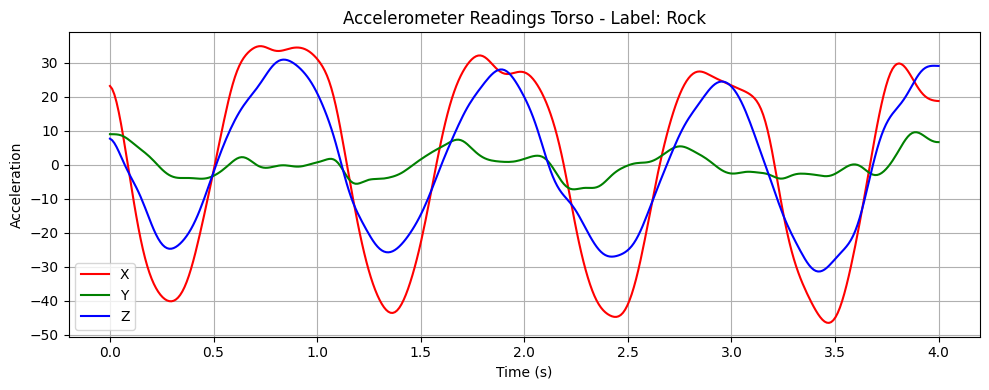

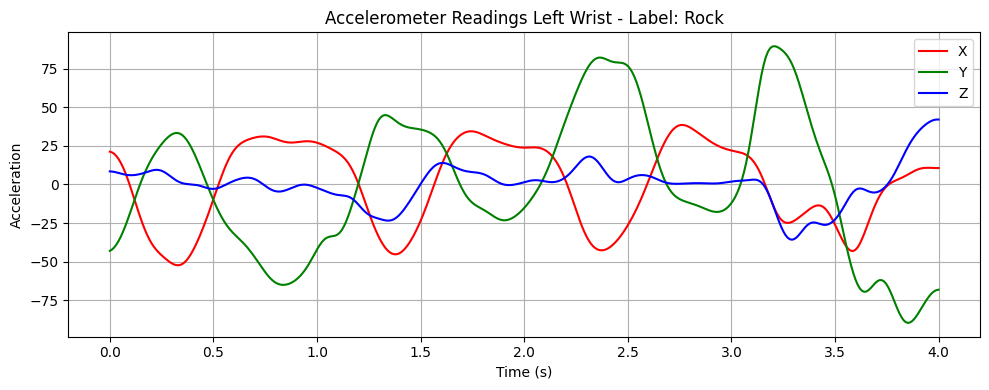

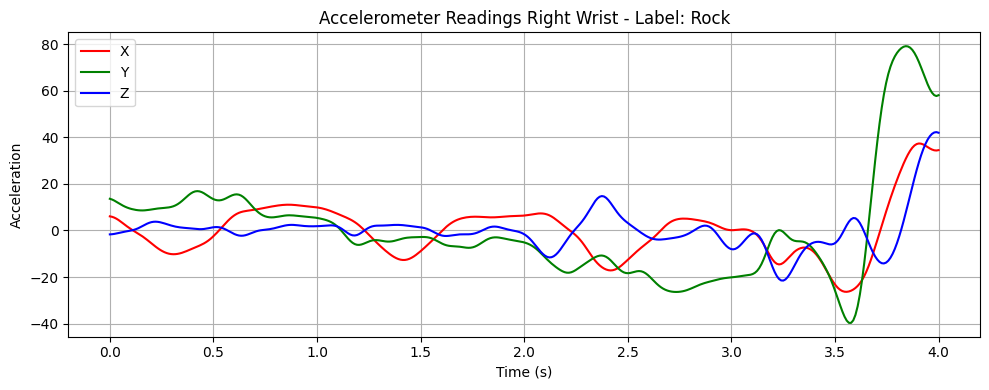

In [14]:
# Plot
plt.figure(figsize=(10, 4))
plt.plot(scoring_pipeline_torso.time_values, scoring_pipeline_torso.X_detrended[:,0], color='r', label='X')
plt.plot(scoring_pipeline_torso.time_values, scoring_pipeline_torso.X_detrended[:,1] , color='g', label='Y')
plt.plot(scoring_pipeline_torso.time_values, scoring_pipeline_torso.X_detrended[:,2] , color='b', label='Z')
plt.title(f"Accelerometer Readings Torso - Label: {label}")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(scoring_pipeline_lwrist.time_values, scoring_pipeline_lwrist.X_detrended[:,0], color='r', label='X')
plt.plot(scoring_pipeline_lwrist.time_values, scoring_pipeline_lwrist.X_detrended[:,1] , color='g', label='Y')
plt.plot(scoring_pipeline_lwrist.time_values, scoring_pipeline_lwrist.X_detrended[:,2] , color='b', label='Z')
plt.title(f"Accelerometer Readings Left Wrist - Label: {label}")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(scoring_pipeline_rwrist.time_values, scoring_pipeline_rwrist.X_detrended[:,0] , color='r', label='X')
plt.plot(scoring_pipeline_rwrist.time_values, scoring_pipeline_rwrist.X_detrended[:,1] , color='g', label='Y')
plt.plot(scoring_pipeline_rwrist.time_values, scoring_pipeline_rwrist.X_detrended[:,2] , color='b', label='Z')
plt.title(f"Accelerometer Readings Right Wrist - Label: {label}")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
# Torso
scoring_pipeline_torso._estimate_period()
period_torso = scoring_pipeline_torso.period
print(f'Estimated Period Torso: {period_torso}')
print('')
# Left Wrist
scoring_pipeline_lwrist._estimate_period()
period_lwrist = scoring_pipeline_lwrist.period
print(f'Estimated Period Left Wrist: {period_lwrist}')
print('')
# Right Wrist
scoring_pipeline_rwrist._estimate_period()
period_rwrist = scoring_pipeline_rwrist.period
print(f'Estimated Period Right Wrist: {period_rwrist}')


Estimated Period Torso: 1.1029023746701847

Estimated Period Left Wrist: 1.1

Estimated Period Right Wrist: 3.7


In [9]:

from sklearn.decomposition import PCA

def plot_sw_point_cloud(SW, title_prefix="Sensor", color=None):
    
    pca = PCA(n_components=2)
    proj_2D = pca.fit_transform(SW)

    plt.figure(figsize=(6, 5))
    plt.scatter(proj_2D[:, 0], proj_2D[:, 1], s=10, alpha=0.7, color=color)
    plt.title(fr'{title_prefix} SW Point Cloud')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return SW

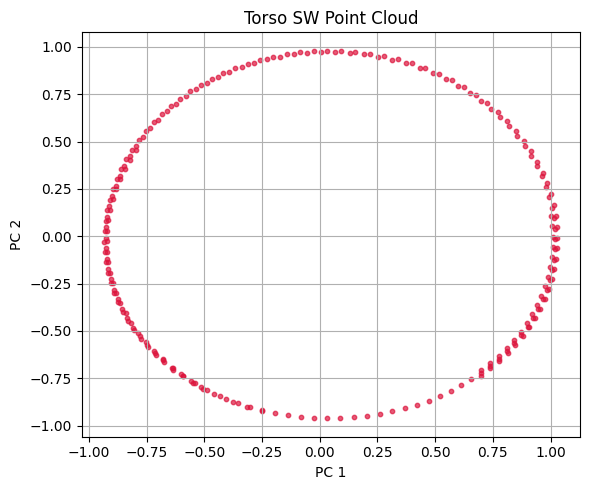

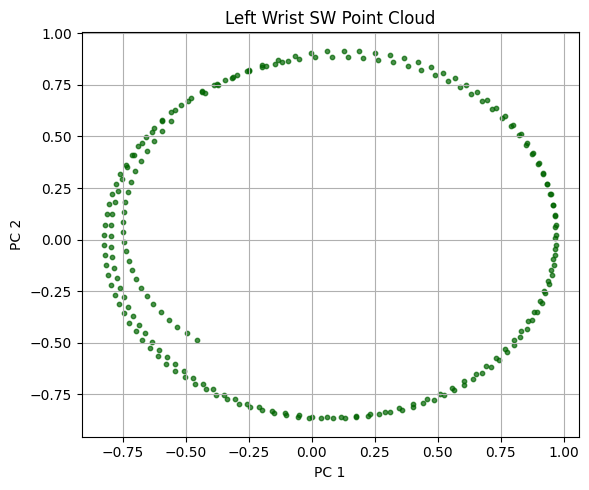

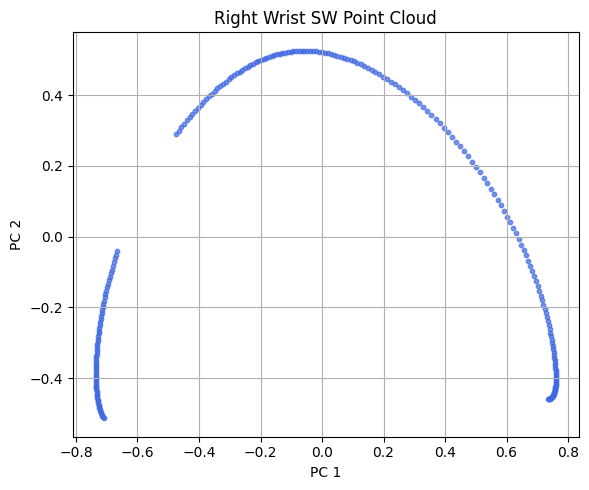

In [16]:
#Compute Sliding Window Point Cloud
scoring_pipeline_torso._sliding_windows()
scoring_pipeline_lwrist._sliding_windows()
scoring_pipeline_rwrist._sliding_windows()
# Torso
SW_torso = plot_sw_point_cloud(
    scoring_pipeline_torso.SW, title_prefix="Torso", color='crimson'
)

# Left Wrist
SW_lwrist = plot_sw_point_cloud(
    scoring_pipeline_lwrist.SW, title_prefix="Left Wrist", color='darkgreen'
)

# Right Wrist
SW_rwrist = plot_sw_point_cloud(
    scoring_pipeline_rwrist.SW, title_prefix="Right Wrist", color='royalblue'
)


In [11]:

def plot_score(diagrams, scores, method = 'PS1', sensor_name="Sensor"):
    """Plot persistence diagram + PS scores."""
    if method == 'PS10':
        num = 10
        x_lim = 9.5
    else:
        num = 1
        x_lim = 0.5
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 
    plot_diagrams(diagrams, plot_only=[1], xy_range=[0, 2, 0, 2], ax=axes[0])
    axes[0].set_title(fr"{sensor_name} - Persistence Diagram")

    axes[1].bar(range(num), scores, alpha=0.5)
    if method =='PS10':
        axes[1].set_title(f"{sensor_name} -" + r" $PS_{10}$ Score")
    else:
        axes[1].set_title(fr"{sensor_name} - $PS_1$ Score")
    axes[1].set_xlim(-0.5, x_lim)
    axes[1].set_ylim(0, 1)
    axes[1].set_xticks([])

    plt.tight_layout()
    plt.show()


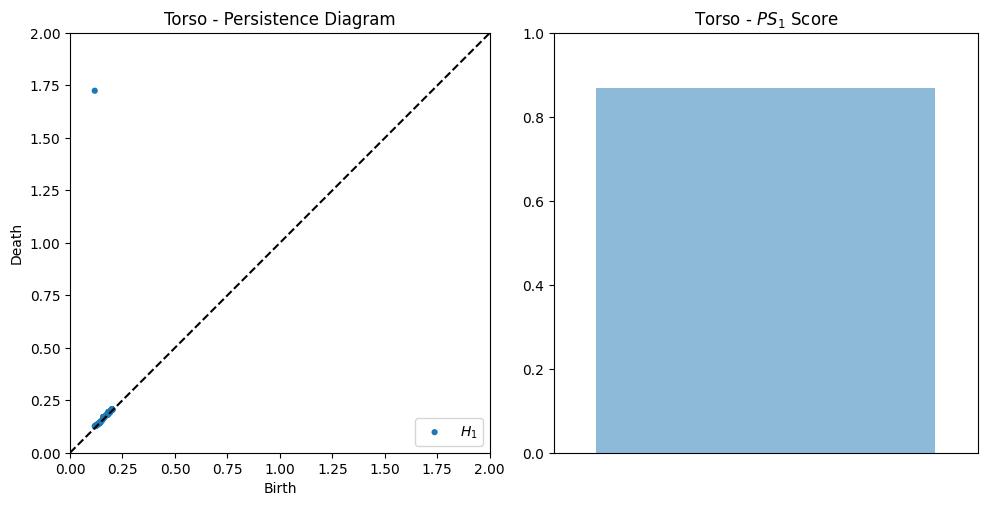

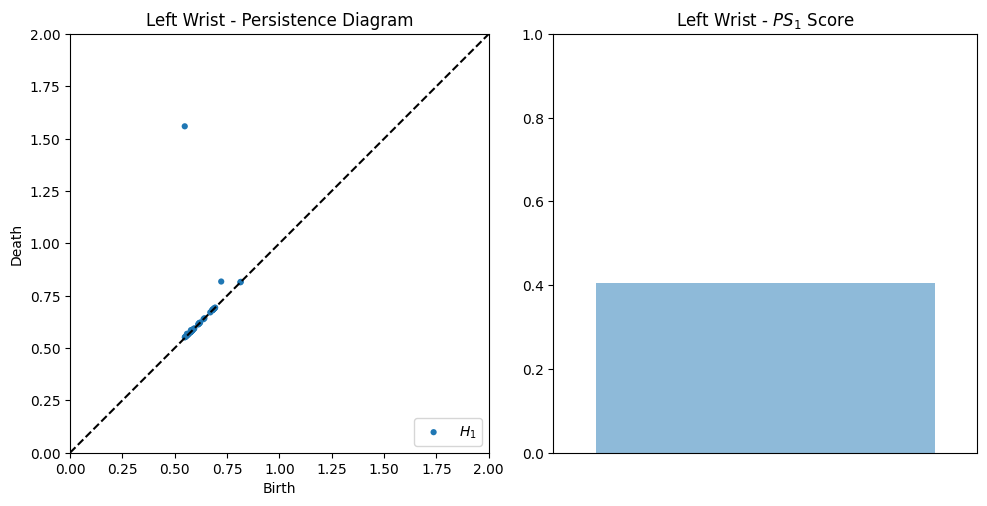

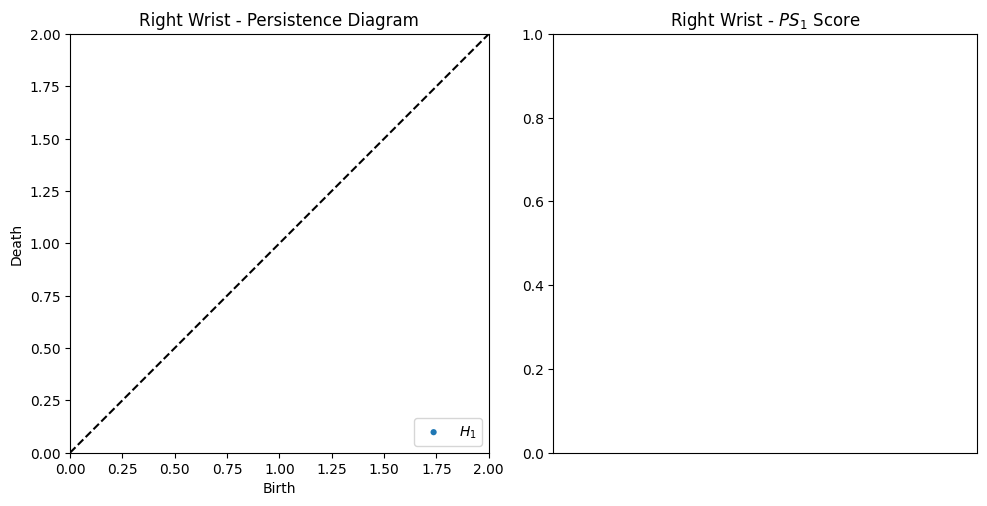

In [17]:
scoring_pipeline_torso._1PerS()
scoring_pipeline_lwrist._1PerS()
scoring_pipeline_rwrist._1PerS()

plot_score(scoring_pipeline_torso.diagram,scoring_pipeline_torso.periodicity_score, method, sensor_name="Torso")
plot_score(scoring_pipeline_lwrist.diagram,scoring_pipeline_lwrist.periodicity_score, method, sensor_name="Left Wrist")
plot_score(scoring_pipeline_rwrist.diagram,scoring_pipeline_rwrist.periodicity_score, method, sensor_name="Right Wrist")
